In [6]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline

In [7]:
dataset = pd.read_csv('train.csv')

## The original dataset contained both Training and Testing data,
## but we had to drop the Testing data because we didn't know the outcomes.

In [8]:
print('Dataset Shape:', dataset.shape)

## Initial view of the size of the data - 80 variables plus an ID

Dataset Shape: (1460, 81)


In [12]:
dataset.head()

## Initial view of the content of the data
## Variables include both continuous and discrete data
## Missing data appears as NaN (not a number)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1.000000,2.783158,RL,65.0,9.587694,Pave,NaN,Reg,Lvl,AllPub,...,0.0,NaN,NaN,NaN,0,1.189207,6.694080,WD,Normal,208500
1,1.189207,2.114743,RL,80.0,9.898464,Pave,NaN,Reg,Lvl,AllPub,...,0.0,NaN,NaN,NaN,0,1.495349,6.693247,WD,Normal,181500
2,1.316074,2.783158,RL,68.0,10.298836,Pave,NaN,IR1,Lvl,AllPub,...,0.0,NaN,NaN,NaN,0,1.732051,6.694080,WD,Normal,223500
3,1.414214,2.892508,RL,60.0,9.885550,Pave,NaN,IR1,Lvl,AllPub,...,0.0,NaN,NaN,NaN,0,1.189207,6.692413,WD,Abnorml,140000
4,1.495349,2.783158,RL,84.0,10.927728,Pave,NaN,IR1,Lvl,AllPub,...,0.0,NaN,NaN,NaN,0,1.861210,6.694080,WD,Normal,250000


In [13]:
dict = {}

## We will attempt to standardize the data by trying a few different operators
## and choosing whichever produces the highest correlation. In many cases, the
## data will already be optimized as-is. Below, we have printed the ideal operator
## in case we want to drill down and get a better understanding of the correlation.

for i in dataset.columns:
    typ = ['float64','int64','float32','int32']
    if dataset[i].dtype in typ and i != 'SalePrice':
        corr = {'asis':0, 'log':0, 'exp':0, 'sqrt':0, 'pow2':0} 
    
        if all((dataset[i]>=0)):
            corr['log'] = abs(np.corrcoef(np.log(dataset[i] + 0.00001), dataset[i])[1][0])
            corr['exp'] = abs(np.corrcoef(np.exp(dataset[i] + 0.00001), dataset[i])[1][0])
            corr['sqrt'] = abs(np.corrcoef(np.sqrt(dataset[i] + 0.00001), dataset[i])[1][0])
            corr['pow2'] = abs(np.corrcoef(np.power(dataset[i] + 0.00001,2), dataset[i])[1][0])
            corr['pow4'] = abs(np.corrcoef(np.power(dataset[i] + 0.00001,4), dataset[i])[1][0])
            highest = max(corr, key=corr.get)
            if highest == 'log':
                dataset[i] = dataset[i].apply(lambda x: np.log(x))
            if highest == 'exp':
                dataset[i] = dataset[i].apply(lambda x: np.exp(x))
            if highest == 'sqrt':
                dataset[i] = dataset[i].apply(lambda x: np.sqrt(x))
            if highest == 'pow2':
                dataset[i] = dataset[i].apply(lambda x: np.power(x,2))
            if highest == 'pow4':
                dataset[i] = dataset[i].apply(lambda x: np.power(x,4))
        else:
            corr = {'asis':0, 'log':0, 'exp':0, 'sqrt':0, 'pow2':0, 'pow4':0}
    dict[i] = max(corr, key=corr.get)
dict

{'Id': 'sqrt',
 'MSSubClass': 'sqrt',
 'MSZoning': 'sqrt',
 'LotFrontage': 'asis',
 'LotArea': 'sqrt',
 'Street': 'sqrt',
 'Alley': 'sqrt',
 'LotShape': 'sqrt',
 'LandContour': 'sqrt',
 'Utilities': 'sqrt',
 'LotConfig': 'sqrt',
 'LandSlope': 'sqrt',
 'Neighborhood': 'sqrt',
 'Condition1': 'sqrt',
 'Condition2': 'sqrt',
 'BldgType': 'sqrt',
 'HouseStyle': 'sqrt',
 'OverallQual': 'sqrt',
 'OverallCond': 'sqrt',
 'YearBuilt': 'sqrt',
 'YearRemodAdd': 'sqrt',
 'RoofStyle': 'sqrt',
 'RoofMatl': 'sqrt',
 'Exterior1st': 'sqrt',
 'Exterior2nd': 'sqrt',
 'MasVnrType': 'sqrt',
 'MasVnrArea': 'asis',
 'ExterQual': 'asis',
 'ExterCond': 'asis',
 'Foundation': 'asis',
 'BsmtQual': 'asis',
 'BsmtCond': 'asis',
 'BsmtExposure': 'asis',
 'BsmtFinType1': 'asis',
 'BsmtFinSF1': 'sqrt',
 'BsmtFinType2': 'sqrt',
 'BsmtFinSF2': 'sqrt',
 'BsmtUnfSF': 'sqrt',
 'TotalBsmtSF': 'sqrt',
 'Heating': 'sqrt',
 'HeatingQC': 'sqrt',
 'CentralAir': 'sqrt',
 'Electrical': 'sqrt',
 '1stFlrSF': 'sqrt',
 '2ndFlrSF': 'sqr

In [14]:
nans = []

## We need to delete any columns with incomplete data.
## First we aggregate these columns into a subset, then drop them from the dataset.


for i in dataset.columns:
    if (float(dataset[i].isnull().sum())/dataset[i].shape[0]) > 0:
        nans.append(i)
dataset = dataset.drop(nans, axis=1)
dataset = dataset.drop(columns = 'Id', axis=1)

In [15]:
## For discrete nominal and ordinal variables, we need to assign
## arbitrary integers (based on index number) in order to analyze.
## Our data set is now enriched with categorical variables.

for i in dataset.columns:
    namu = dataset[i].unique()
    ind = dataset[i].index
    typ = ['float64', 'float32', 'int64', 'int32']
    if dataset[i].dtype in typ:
        dataset = dataset
    else:
        dat = pd.DataFrame(list(zip(namu, ind)), columns = [i,'Ind'])
        dataset[i] = dataset[i].map(dat.set_index(i)['Ind'])

In [179]:
print('New Training Set Shape:', dataset.shape)

New Training Set Shape: (1460, 61)


In [180]:
dataset.head()

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,2.783158,0,9.587694,0,0,0,0,0,0,0,...,0.000000,0.0,0.0,0.0,0,1.189207,6.694080,0,0,208500
1,2.114743,0,9.898464,0,0,0,0,1,0,1,...,0.000000,0.0,0.0,0.0,0,1.495349,6.693247,0,0,181500
2,2.783158,0,10.298836,0,1,0,0,0,0,0,...,0.000000,0.0,0.0,0.0,0,1.732051,6.694080,0,0,223500
3,2.892508,0,9.885550,0,1,0,0,2,0,2,...,4.061086,0.0,0.0,0.0,0,1.189207,6.692413,0,1,140000
4,2.783158,0,10.927728,0,1,0,0,1,0,3,...,0.000000,0.0,0.0,0.0,0,1.861210,6.694080,0,0,250000


In [181]:
## Define X by randomly splitting a training set from the testing set.
## Define Y as the dependent variable or outcome.


X = dataset[['MSSubClass', 'MSZoning', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'ExterQual', 'ExterCond', 'Foundation',
       'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional',
       'GarageCars', 'GarageArea',
       'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SaleType',
       'SaleCondition']].values
Y = dataset[['SalePrice']].values
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.1, random_state=0)

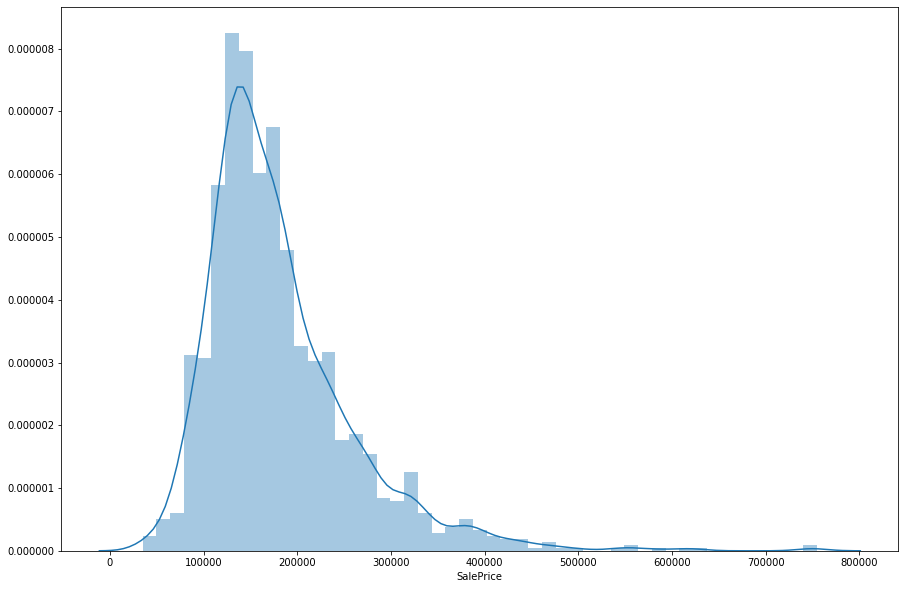

In [16]:
plt.figure(figsize=(15,10))
plt.tight_layout()
seabornInstance.distplot(dataset['SalePrice']) ## rough histogram of SalePrice

In [183]:
## define the regression function for the training set

reg = LinearRegression()  
reg.fit(Xtrain, Ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [184]:
## define the outcome function for the testing set

ypred = reg.predict(Xtest)

In [185]:
## compare predicted to actual values by creating a single dataframe with each as a column

df = pd.DataFrame(ypred, columns=['Predicted'])
df2 = pd.DataFrame(Ytest, columns=['Actual'])
df = df.join(df2)
df


,Predicted,Actual
0,254329.517150,200624
1,168733.472272,133000
2,89323.463351,110000
3,233481.905900,192000
4,83115.913498,88000
...,...,...
141,141259.207696,145000
142,264688.337219,217000
143,147986.030846,150500
144,148493.730303,108959


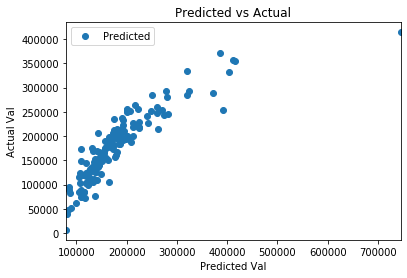

In [186]:
## Visualize the data in a scatterplot, with axis labels and a title

df.plot(x='Actual', y='Predicted', style='o')  
plt.title('Predicted vs Actual')  
plt.xlabel('Predicted Val')  
plt.ylabel('Actual Val')  
plt.show()

In [187]:
## Key performance indicators
## Error is high, indicating a lack of statistically significant accuracy
## The model still trends correctly, and provides a fair estimate of SalePrice.

print('Mean Absolute Error:', metrics.mean_absolute_error(Ytest, ypred))
print('Mean Squared Error:', metrics.mean_squared_error(Ytest, ypred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Ytest, ypred)))

Mean Absolute Error: 24329.449355612338
Mean Squared Error: 1666412230.812962
Root Mean Squared Error: 40821.71273737742
